In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("code")

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.io.wavfile as wave
from tqdm import tqdm_notebook
import IPython
import sklearn.decomposition as skd

import utils
import em

# Reading data

In [2]:
rate, _, mix = utils.readwav('data/mix.wav')
maxi = np.max(mix)
mix = mix / maxi

T, I = mix.shape
print("rate = {}".format(rate))
print("T = {}".format(T))
print("I = {}".format(I))
IPython.display.Audio(mix.transpose(), rate = rate)

rate = 16000
T = 300801
I = 2


In [3]:
sources, true_sources = utils.create_inputs(maxi = maxi)
J = sources.shape[0]
print("J = {}".format(J))

J = 3


F = 501
N = 603


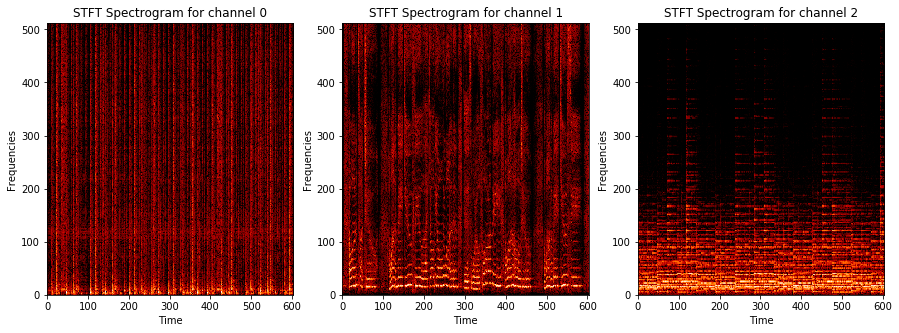

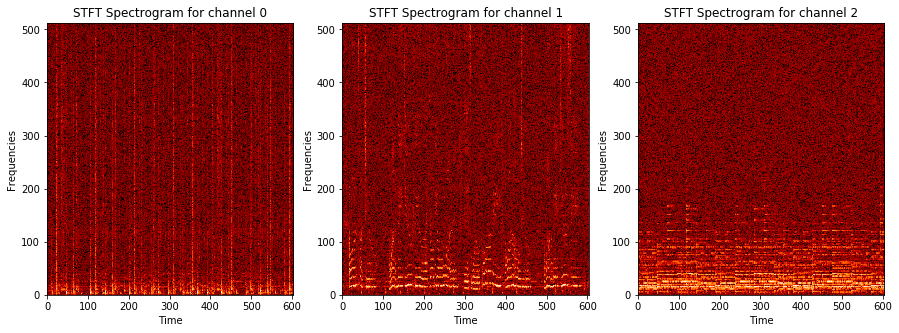

In [4]:
freqs, _, S = sig.stft(sources, fs=rate, nperseg=1000)
_, _, true_S = sig.stft(true_sources, fs=rate, nperseg=1000)
_, _, X = sig.stft(mix.transpose(), fs=rate, nperseg=1000)

F = len(freqs)
N = S[0].shape[-1]
print("F = {}".format(F))
print("N = {}".format(N))

utils.plot_stft(freqs, true_S)
utils.plot_stft(freqs, S)
true_S = true_S.transpose(1, 2, 0)
S = S.transpose(1, 2, 0)
X = X.transpose(1, 2, 0)

output = utils.resynthesize_src(S, maxi)
IPython.display.Audio(output[0].transpose() * maxi, rate = rate)

# Algorithm
## Parameters initialization

In [ ]:
Kpart = [5, 6, 8]
K = np.sum(Kpart)
print("K     = {}".format(K))
print("Kpart = {}".format(Kpart))

A, W, H, sigma_b = em.init_params(X, S, Kpart)

K     = 19
Kpart = [5, 6, 8]


## Iterations

In [ ]:
n_iter = 25
loglikes = []
for _ in tqdm_notebook(range(n_iter)):
    Rxx, Rxs, Rss, U, S = em.compute_E_step(X, A, W, H, sigma_b, Kpart)
    A, sigma_b, W, H = em.compute_M_step(Rxx, Rxs, Rss, U, W, H)
    loglikes += [utils.compute_loglike(true_S, W, H, Kpart)]
    
utils.plot_loglike(loglikes)

## Reconstruction

In [ ]:
utils.plot_stft(freqs, S.transpose(2, 0, 1))
output = utils.resynthesize_src(S, maxi)
IPython.display.Audio(output[0].transpose() * maxi, rate = rate)